## Bikeshare rides (Winter 2018)

This notebook creates images and gifs of hourly station usage maps using data from Jan, Feb and March 2018. Image files are stored in the "./Images" folder. The maps are created using the tilemapbase package found here: https://github.com/MatthewDaws/TileMapBase

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

In [6]:
# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
import tilemapbase
tilemapbase.start_logging()

In [7]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [8]:
t = tilemapbase.tiles.Carto_Light

In [9]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

In [2]:
#Import winter dataframes and set number of days
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')

In [3]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend']
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend']

In [4]:
#Create the weekday hourly station cmap dataframe
WD_pickup_groupby = weekday_subs_trips_df.groupby(['pickup_hour', 'start station id'],axis=0)

hourly_pickups_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
hourly_pickups_cmaps_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
WD_max_pickups = WD_pickup_groupby['starttime'].count().max()
WD_max_pickup_cap = WD_pickup_groupby['starttime'].count().sort_values(ascending = False).iloc[4] #Set cap at top 5

WD_dropoff_groupby = weekday_subs_trips_df.groupby(['dropoff_hour', 'start station id'],axis=0)

hourly_dropoffs_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
hourly_dropoffs_cmaps_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
WD_max_dropoffs = WD_dropoff_groupby['starttime'].count().max()
WD_max_dropoff_cap = WD_dropoff_groupby['starttime'].count().sort_values(ascending = False).iloc[4]

cmap = cm.get_cmap('jet')
#cmap = cm.get_cmap('YlOrRd')
#cmap = cm.get_cmap('afmhot_r')
#cmap = cm.get_cmap('cool')


for num in range(24):
    WD_num_pickups = WD_pickup_groupby['starttime'].count()[num]
    WD_num_dropoffs = WD_dropoff_groupby['starttime'].count()[num]
    
    hourly_pickups_df[num] = WD_num_pickups
    hourly_dropoffs_df[num] = WD_num_dropoffs
    
    hourly_pickups_df = hourly_pickups_df.fillna(0)
    hourly_dropoffs_df = hourly_dropoffs_df.fillna(0)
        
    hourly_pickups_cmaps_df[num] = hourly_pickups_df[num].map(lambda x: cmap(x/WD_max_pickup_cap))
    hourly_dropoffs_cmaps_df[num] = hourly_dropoffs_df[num].map(lambda x: cmap(x/WD_max_dropoff_cap))
    

In [71]:
#Do the same for weekend trips

WE_pickup_groupby = weekend_subs_trips_df.groupby(['pickup_hour', 'start station id'],axis=0)

WE_hourly_pickups_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
WE_hourly_pickups_cmaps_df = pd.DataFrame(index=stations_info_df.index, columns=list(range(24)))
WE_max_pickups = WE_pickup_groupby['starttime'].count().max()
WE_max_pickup_cap = WE_pickup_groupby['starttime'].count().sort_values(ascending = False).iloc[4] # Set cap at top 5

cmap = cm.get_cmap('jet')

for num in range(24):
    WE_num_pickups = WE_pickup_groupby['starttime'].count()[num]
    WE_hourly_pickups_df[num] = WE_num_pickups
    WE_hourly_pickups_df = WE_hourly_pickups_df.fillna(0)
    WE_hourly_pickups_cmaps_df[num] = WE_hourly_pickups_df[num].map(lambda x: cmap(x/WE_max_pickup_cap))
    

In [79]:
#Create weekday images
plt.ioff()

for num in range(24):
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    ax.scatter(x,y, marker = 'h', color = hourly_pickups_cmaps_df[num], alpha = .5, s = 100)#, animated=True);
    #plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
    ax.set_title('Winter 2018, weekday, hour = {}'.format(num))
        
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
    cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WD_max_pickup_cap/num_WD/2) , '> ' +  '{:.1f} per day'.format(WD_max_pickup_cap/num_WD)])# vertically oriented colorbar
    
    
    plt.savefig('./Images/Winter_2018/Winter_2018_WD_{}.png'.format(str(num)));
    plt.close()
    
for num in range(24):
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    ax.scatter(x,y, marker = 'h', color = hourly_dropoffs_cmaps_df[num], alpha = .5, s = 100)#, animated=True);
       
    #plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
    
    ax.set_title('Winter 2018, weekday dropoffs, hour = {}'.format(num))
    
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
    cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WD_max_dropoff_cap/2/num_WD) , '> ' +  '{:.1f} per day'.format(WD_max_dropoff_cap/num_WD)])# vertically oriented colorbar
    
    plt.savefig('./Images/Winter_2018/Winter_2018_WD_drops_{}.png'.format(str(num)));
    plt.close()

In [80]:
#Create weekend images
plt.ioff()

for num in range(24):
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    ax.scatter(x,y, marker = 'h', color = WE_hourly_pickups_cmaps_df[num], alpha = .5, s = 100)#, animated=True);
       
    #plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
    
    ax.set_title('Winter 2018, weekend, hour = {}'.format(num))
    
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
    cbar.ax.set_yticklabels(['0', '{:.1f} per day'.format(WE_max_pickup_cap/2/num_WE) , '> ' + '{:.1f} per day'.format(WE_max_pickup_cap/num_WE)])# vertically oriented colorbar
    
    plt.savefig('./Images/Winter_2018/Winter_2018_WE_{}.png'.format(str(num)));
    
    plt.close()


In [81]:
from PIL import Image

#Weekday and weekend image gifs
WD_ims = []
WD_drops_ims = []

WE_ims = []
WE_drops_ims = []

for num in range(24):
    WD_im = Image.open('./Images/Winter_2018/Winter_2018_WD_{}.png'.format(str(num)))
    WD_ims.append(WD_im)
    
    WD_drops_im = Image.open('./Images/Winter_2018/Winter_2018_WD_drops_{}.png'.format(str(num)))
    WD_drops_ims.append(WD_drops_im)
    
    WE_im = Image.open('./Images/Winter_2018/Winter_2018_WE_{}.png'.format(str(num)))
    WE_ims.append(WE_im)

WD_ims[0].save('./Images/Winter_2018/Winter_2018_WD.gif',
               save_all=True,
               append_images=WD_ims[1:],
               duration=600,
               loop=0)

WD_drops_ims[0].save('./Images/Winter_2018/Winter_2018_WD_drops.gif',
               save_all=True,
               append_images=WD_drops_ims[1:],
               duration=600,
               loop=0)

WE_ims[0].save('./Images/Winter_2018/Winter_2018_WE.gif',
               save_all=True,
               append_images=WE_ims[1:],
               duration=600,
               loop=0)


<IPython.core.display.Javascript object>


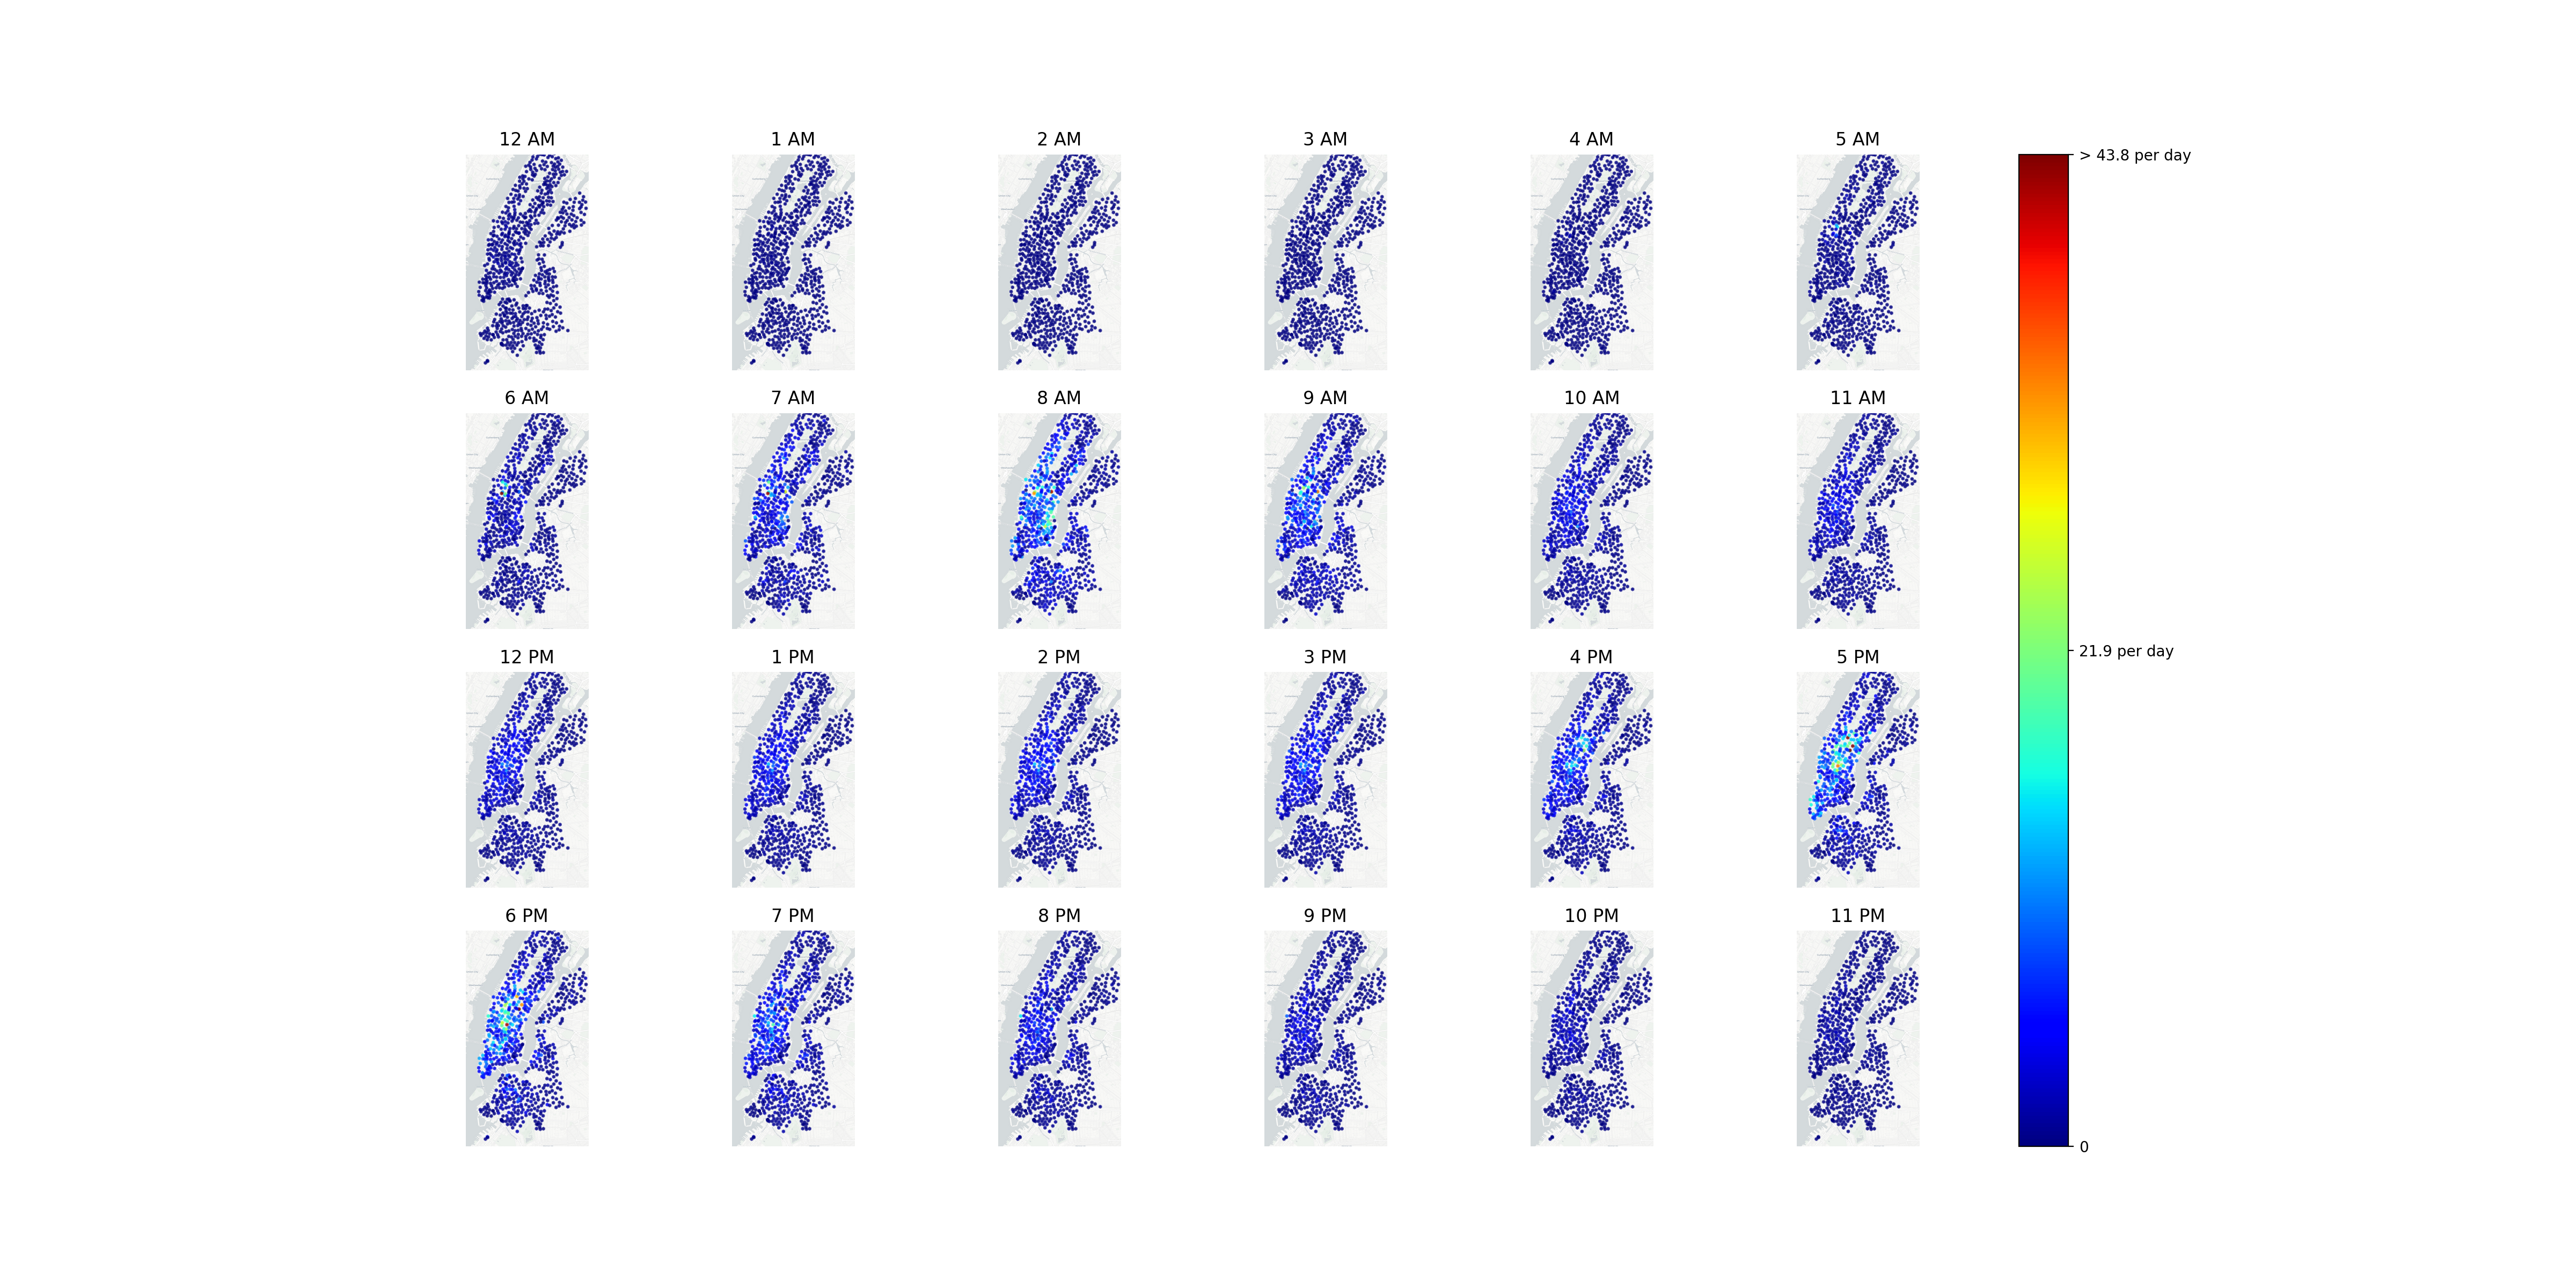

In [12]:
fig, ax = plt.subplots(nrows = 4, ncols =6, figsize=(24,12), dpi=100)
ax = ax.flatten()
plt.subplots_adjust(wspace = 0)

for num in range(24):
    
    ax[num].axis('off')
    
    if num == 0:
        ax[num].set_title('{} AM'.format(str(12)))
    elif num == 12:
        ax[num].set_title('{} PM'.format(str(12)))
    elif num < 12:
        ax[num].set_title('{} AM'.format(str(num % 12)))
    else:
        ax[num].set_title('{} PM'.format(str(num % 12)))

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax[num], t)
    
    ax[num].scatter(x,y, marker = 'h', color = hourly_pickups_cmaps_df[num], alpha = .7, s = 2.5)#, animated=True);
    #ax[num].annotate('hour = {}'.format(num), [x_cen,y_cen]);
        
cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WD_max_dropoff_cap/2/num_WD) , '> ' +  '{:.1f} per day'.format(WD_max_dropoff_cap/num_WD)])# vertically oriented colorbar

plt.show()
